# Binned likelihood fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Define fit model

In [2]:
tmax = 100

# Exponential decay + uniform background

def myfun(x,par):

    # decay time
    
    tdec = par[0]
    
    # Decay normalisation
    
    ndec = par[1]

    # Background normalisation
    
    nbg = par[2]
    
    # Exponential probability distribution
    
    val = ndec/tdec * np.exp(-x/tdec)

    # Add constant term
    
    val += nbg 

    return val

# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,3))

    # decay time
    
    tdec = par[0]
    
    # Decay normalisation
    
    ndec = par[1]

    # Background normalisation
    
    nbg = par[2]
    
    # Exponential probability distribution
    
    val = 1/tdec * np.exp(-x/tdec)

    der[:,0] = ndec*val*(x-tdec)/tdec/tdec
    
    der[:,1] = val
    
    der[:,2] =  1.
    
    val = ndec*val + nbg

    return val,der

# myfunder(np.array([0.,1.,2.,3.,4.,5.,6.,7.]),np.array([2.2,1000.,10.]))

### (2) Read input data

In [3]:
# Nevt = 100
# infile = "http://hep.fuw.edu.pl/u/zarnecki/saed23/11_example_data_"+str(Nevt)+".dat"

# Old data (as shown in lecture slides)

Nevt = 10000
infile = "http://hep.fuw.edu.pl/u/zarnecki/saed22/10_example_data_"+str(Nevt)+".dat"


ttab = np.loadtxt(infile)

In [4]:
# Create  histogram

tmax = 100.
Nbin = 100

counts, bins = np.histogram(ttab,range=[0,tmax],bins=Nbin)

xvec = bins[:Nbin] + bins[1]/2.
yvec = counts


### (3) Iterative fit

In [5]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 3

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 2.*Nevt
parini[2] = 0.01*Nevt

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

loglini = np.sum(yvec*np.log(fini)-fini)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  LL = %8.3f   LL/Ndf = %8.5f " % (loglini,loglini/xvec.size))


Iterative fit procedure starting from parameter values
  [2.e+00 2.e+04 1.e+02]
  LL = 45113.367   LL/Ndf = 451.13367 


In [6]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.001   # Required precision (distance from minimum)

loglmin = loglini
parmin = parini

par = parini

parhist = []
parhist.append(par)

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*(yvec/fval - 1))
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]*yvec/fval/fval)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
        C[l,l] += lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    loglnew = np.sum(yvec*np.log(fnew)-fnew)

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    if loglnew > loglmin :
        print("\nIteration step ",Nit," with lambda = ",lam)
        print(" ",parnew)
        print("  LL =  %8.3f   LL/Ndf = %8.5f " % (loglnew,loglnew/(xvec.size-Nfun)))
        print("  distance to minimum: ",dist)
    
        lam /= 10
        loglmin = loglnew
        par = parnew
    else:
        lam *= 10

    parhist.append(par)


Iteration step  3  with lambda =  1.0
  [2.1594612e+00 1.9999410e+04 3.4495713e+01]
  LL =  49461.995   LL/Ndf = 509.91747 
  distance to minimum:  5111.097246367396

Iteration step  5  with lambda =  1.0
  [2.28727020e+00 1.99988271e+04 1.63064588e+01]
  LL =  49899.734   LL/Ndf = 514.43025 
  distance to minimum:  830.8458968653866

Iteration step  6  with lambda =  0.1
  [2.32102687e+00 1.99930066e+04 1.77847741e+01]
  LL =  49912.185   LL/Ndf = 514.55861 
  distance to minimum:  18.78093752733166

Iteration step  7  with lambda =  0.01
  [2.32932559e+00 1.99349272e+04 1.79506556e+01]
  LL =  49946.094   LL/Ndf = 514.90819 
  distance to minimum:  34.03882332197936

Iteration step  8  with lambda =  0.001
  [2.33005517e+00 1.93656899e+04 1.79923295e+01]
  LL =  50273.350   LL/Ndf = 518.28196 
  distance to minimum:  330.6114083253749

Iteration step  9  with lambda =  0.0001
  [2.31866259e+00 1.46821690e+04 1.83684135e+01]
  LL =  52656.696   LL/Ndf = 542.85254 
  distance to minim

<ipython-input-6-91f228589dea>:57: RuntimeWarning: invalid value encountered in log
  loglnew = np.sum(yvec*np.log(fnew)-fnew)


In [7]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

logl = np.sum(yvec*np.log(fvec)-fvec)

print("\n LL =  %8.3f   LL/Ndf = %8.5f " % (logl,logl/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     2.237  +/-  0.029 
  8075.731  +/- 91.907 
    19.911  +/-  0.481 

 Correlation matrix

[ 1.     0.057 -0.143]
[ 0.057  1.    -0.07 ]
[-0.143 -0.07   1.   ]

 LL =  54376.906   LL/Ndf = 560.58666 


### (4) Draw data and fit

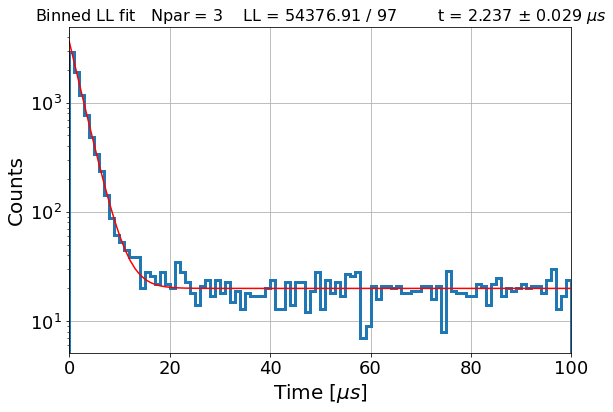

In [8]:
Nf = 100
xfun = np.linspace(0.,tmax,Nf)
yfun = myfun(xfun,par)

plt.figure(figsize=(9, 6))

plt.hist(ttab,range=[0,tmax],bins=Nbin,log=True, histtype='step',linewidth=3)
plt.plot(xfun,yfun,'r-')
plt.xlim([0,tmax])

plt.title('Binned LL fit   Npar = {}    LL = {:.2f} / {}        t = {:.3f} $\pm$ {:.3f} $\mu s$'.format(Nfun,logl,xvec.size-Nfun,par[0],epar[0]),size=16)
plt.ylabel('Counts',size=20)
plt.xlabel('Time [$\mu s$]',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '11_binned_fit2_'+str(Nevt)+'_'+str(Nbin)+'.png'
plt.savefig(fname)